# Speaker Identification using Classical Machine Learning

In this notebook, we classify speakers using audio samples. We extract MFCC features and use classical ML models such as:
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Logistic Regression (LR)
- Random Forest (RF)
- Ensemble models: Voting & Stacking

Dataset: Mozilla Common Voice (subset)
Features: MFCC (13 coefficients)


## 1. Setup and Imports
We import the necessary libraries for audio processing, feature extraction, model training, and evaluation.

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier


## 2. Load and Label Audio Data

We use the Mozilla Common Voice dataset. All audio `.wav` files are located in the `clips/` directory. Each audio clip is linked to a speaker via the `client_id` field in `validated.tsv`.

Steps:
- Load metadata (`validated.tsv`)
- Select a subset of speakers (e.g., top 10 with the most recordings)
- Extract MFCCs from each clip and label using `client_id`


data/
└── cv-corpus-21.0-delta-2025-03-14-en
    └── cv-corpus-21.0-delta-2025-03-14
        └── en
            ├── clip_durations.tsv
            ├── clips                                                        <-- all audio .mp3 files here
            │   └── common_voice_en_41980499.mp3                             <-- metadata including speaker_id                    
            ├── invalidated.tsv
            ├── other.tsv
            ├── reported.tsv
            ├── unvalidated_sentences.tsv
            ├── validated_sentences.tsv
            └── validated.tsv

In [10]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# --- Configuration ---
base_dir = "../data/cv-corpus-21.0-delta-2025-03-14-en/cv-corpus-21.0-delta-2025-03-14/en"
clips_dir = os.path.join(base_dir, "clips")
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only necessary columns

# --- Filter all speakers with at least MIN_CLIPS_PER_SPEAKER ---
MIN_CLIPS_PER_SPEAKER = 5

speaker_counts = df['client_id'].value_counts()
eligible_speakers = speaker_counts[speaker_counts >= MIN_CLIPS_PER_SPEAKER].index
df = df[df['client_id'].isin(eligible_speakers)]
df = df.groupby('client_id').head(MIN_CLIPS_PER_SPEAKER)

print(f"Selected {df['client_id'].nunique()} speakers")
print(f"Total samples: {len(df)}")

# --- Feature extraction function ---
def extract_features(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Delta MFCC
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_mean = np.mean(delta_mfcc, axis=1)

    # Chroma STFT
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)

    # Combine all features
    features = np.concatenate([mfcc_mean, delta_mean, chroma_mean, contrast_mean])
    return features

# --- Extract features for all clips ---
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(clips_dir, row['path'])
    try:
        features = extract_features(file_path)
        X.append(features)
        y.append(row['client_id'])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# --- Save processed dataset to .npz ---
save_path = "dataset.npz"
np.savez_compressed(save_path, X=X, y=y)
print(f"Saved features to {save_path}")


Selected 8 speakers
Total samples: 40


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Feature matrix shape: (40, 45)
Labels shape: (40,)
Saved features to dataset.npz


Total unique speakers: 47
Total clips: 249

Speakers with at least N clips:
  ≥ 5 clips: 8 speakers
  ≥ 10 clips: 3 speakers
  ≥ 15 clips: 3 speakers
  ≥ 20 clips: 3 speakers
  ≥ 30 clips: 2 speakers
  ≥ 50 clips: 1 speakers
  ≥ 100 clips: 0 speakers


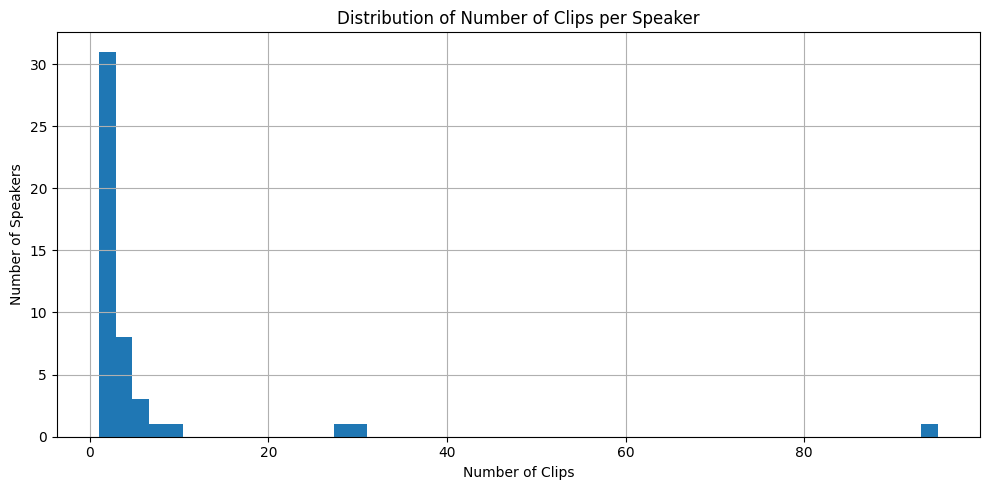

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
#base_dir = "../data/cv-corpus-21.0-delta-2025-03-14-en/cv-corpus-21.0-delta-2025-03-14/en"
base_dir = "../dataset/cv-corpus-18.0-delta-2024-06-14-en/cv-corpus-18.0-delta-2024-06-14/en"
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only relevant columns

# --- Speaker distribution ---
speaker_counts = df['client_id'].value_counts()

print(f"Total unique speakers: {speaker_counts.shape[0]}")
print(f"Total clips: {df.shape[0]}")

# --- Threshold report ---
thresholds = [5, 10, 15, 20, 30, 50, 100]
print("\nSpeakers with at least N clips:")
for t in thresholds:
    count = (speaker_counts >= t).sum()
    print(f"  ≥ {t} clips: {count} speakers")

# --- Plot histogram ---
plt.figure(figsize=(10, 5))
speaker_counts.hist(bins=50)
plt.title("Distribution of Number of Clips per Speaker")
plt.xlabel("Number of Clips")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.tight_layout()
plt.show()


Total unique speakers: 88
Total clips: 326

Speakers with at least N clips:
  ≥ 5 clips: 15 speakers
  ≥ 10 clips: 7 speakers
  ≥ 15 clips: 5 speakers
  ≥ 20 clips: 2 speakers
  ≥ 30 clips: 2 speakers
  ≥ 50 clips: 1 speakers
  ≥ 100 clips: 0 speakers


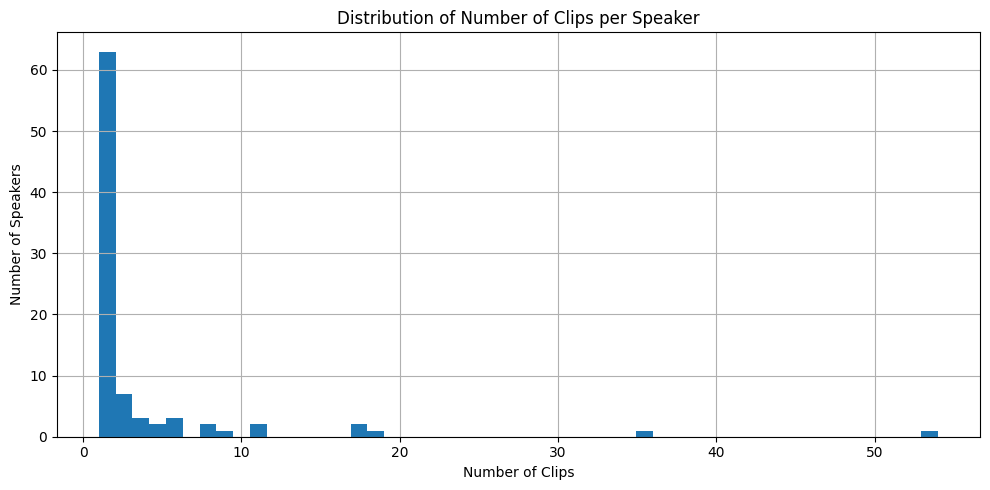

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
#base_dir = "../data/cv-corpus-21.0-delta-2025-03-14-en/cv-corpus-21.0-delta-2025-03-14/en"
base_dir = "../dataset/cv-corpus-18.0-delta-2024-06-14-en/cv-corpus-18.0-delta-2024-06-14/en"
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only relevant columns

# --- Speaker distribution ---
speaker_counts = df['client_id'].value_counts()

print(f"Total unique speakers: {speaker_counts.shape[0]}")
print(f"Total clips: {df.shape[0]}")

# --- Threshold report ---
thresholds = [5, 10, 15, 20, 30, 50, 100]
print("\nSpeakers with at least N clips:")
for t in thresholds:
    count = (speaker_counts >= t).sum()
    print(f"  ≥ {t} clips: {count} speakers")

# --- Plot histogram ---
plt.figure(figsize=(10, 5))
speaker_counts.hist(bins=50)
plt.title("Distribution of Number of Clips per Speaker")
plt.xlabel("Number of Clips")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.tight_layout()
plt.show()


Total unique speakers: 377
Total clips: 3408

Speakers with at least N clips:
  ≥ 2 clips: 156 speakers
  ≥ 5 clips: 66 speakers
  ≥ 10 clips: 41 speakers
  ≥ 15 clips: 31 speakers
  ≥ 20 clips: 26 speakers
  ≥ 30 clips: 17 speakers
  ≥ 50 clips: 10 speakers
  ≥ 100 clips: 5 speakers


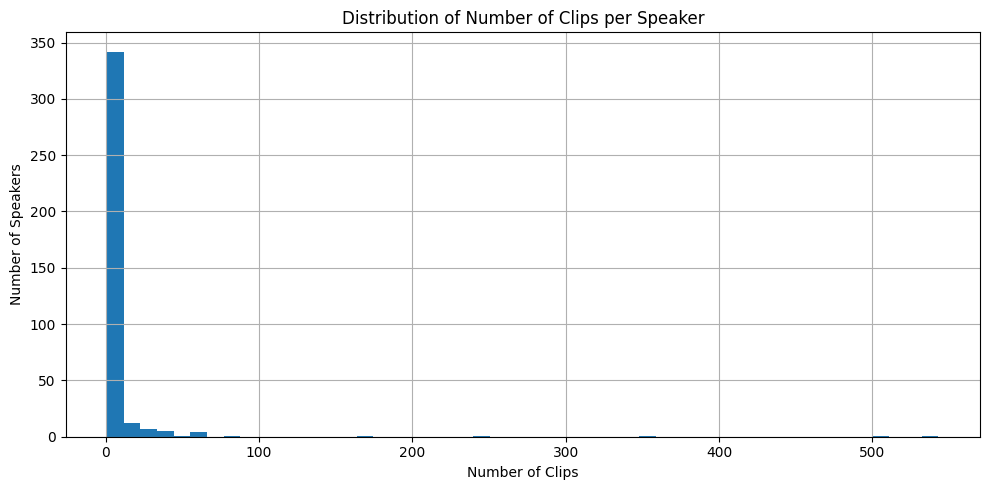

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
#base_dir = "../data/cv-corpus-21.0-delta-2025-03-14-en/cv-corpus-21.0-delta-2025-03-14/en"
base_dir = "../data/cv-corpus-16.1-delta-2023-12-06-en/cv-corpus-16.1-delta-2023-12-06/en"
metadata_file = os.path.join(base_dir, "validated.tsv")

# --- Load metadata ---
df = pd.read_csv(metadata_file, sep="\t")
df = df[['path', 'client_id']]  # Keep only relevant columns

# --- Speaker distribution ---
speaker_counts = df['client_id'].value_counts()

print(f"Total unique speakers: {speaker_counts.shape[0]}")
print(f"Total clips: {df.shape[0]}")

# --- Threshold report ---
thresholds = [2, 5, 10, 15, 20, 30, 50, 100]
print("\nSpeakers with at least N clips:")
for t in thresholds:
    count = (speaker_counts >= t).sum()
    print(f"  ≥ {t} clips: {count} speakers")

# --- Plot histogram ---
plt.figure(figsize=(10, 5))
speaker_counts.hist(bins=50)
plt.title("Distribution of Number of Clips per Speaker")
plt.xlabel("Number of Clips")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Save features and labels for later use
save_path = "processed_speaker_data.npz"
np.savez_compressed(save_path, X=X, y=y)

print(f"Saved features to {save_path}")


Saved features to processed_speaker_data.npz


In [1]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# --- Load models ---
knn = joblib.load("../models/knn_model.joblib")
svm = joblib.load("../models/svm_model.joblib")
lr = joblib.load("../models/logistic_regression_model.joblib")
rf = joblib.load("../models/random_forest_model.joblib")

models = {
    "KNN": knn,
    "SVM": svm,
    "Logistic Regression": lr,
    "Random Forest": rf
}

# --- Evaluate ---
for name, model in models.items():
    print(f"\n Evaluating {name}")

    # Predict
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Optional: 5-Fold Cross-Validation
    cv_scores = cross_val_score(model, X_scaled, y_encoded, cv=5)
    print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



 Evaluating KNN


NameError: name 'X_test' is not defined